In [ ]:
import numpy as np
import pandas as pd
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
import seaborn as sns

experiments = pd.read_parquet("results.parquet")
experiments["error"] = np.abs(experiments["estimate"])
experiments["error_squared"] = experiments["estimate"]**2

range_ns = np.unique(experiments["n"])
range_deltas = np.unique(experiments["delta"])
range_distributions = np.unique(experiments["distribution"])
# range_distributions = ["Gaussian", "St df=1.21", "St df=2.01"]

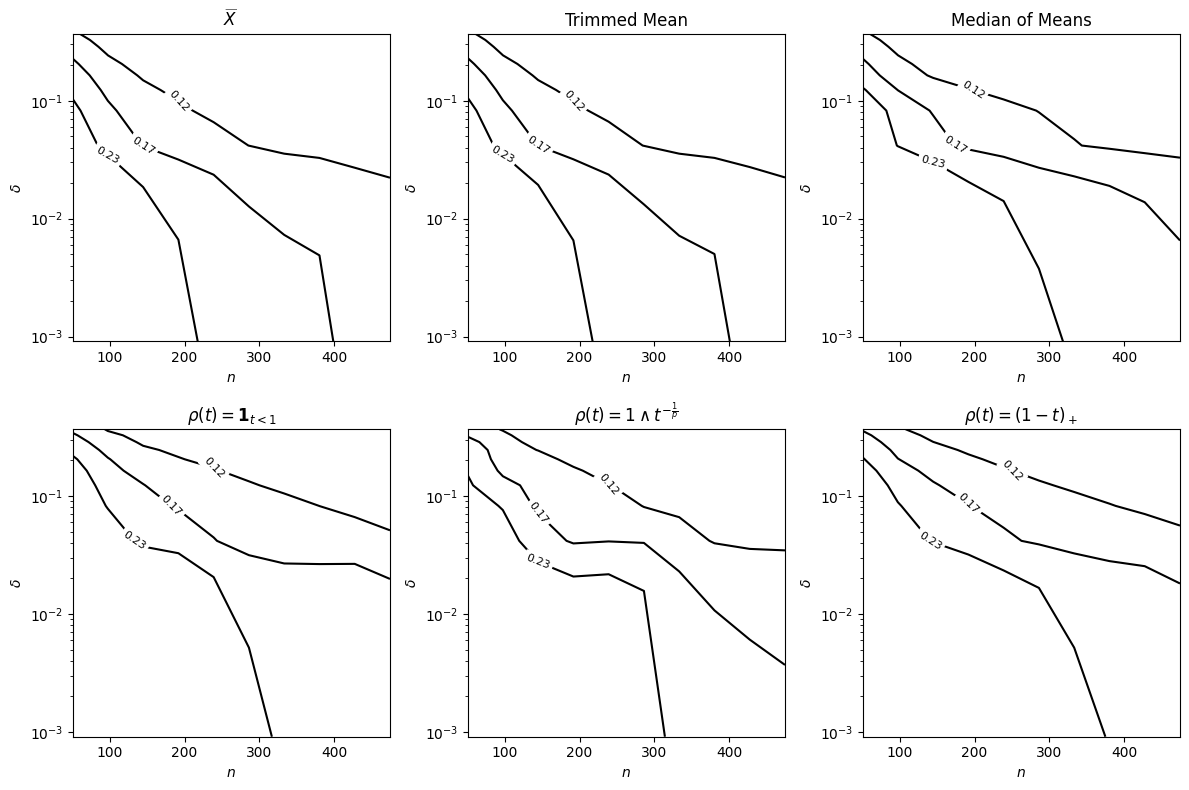

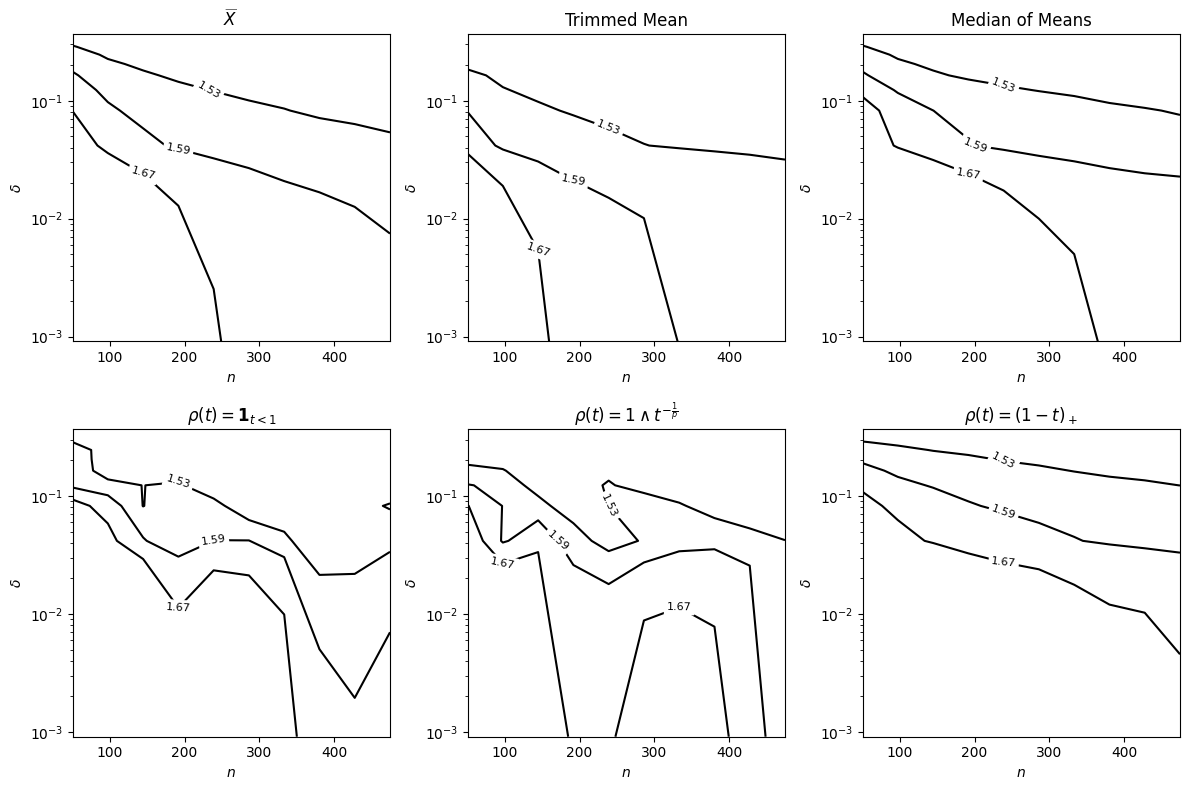

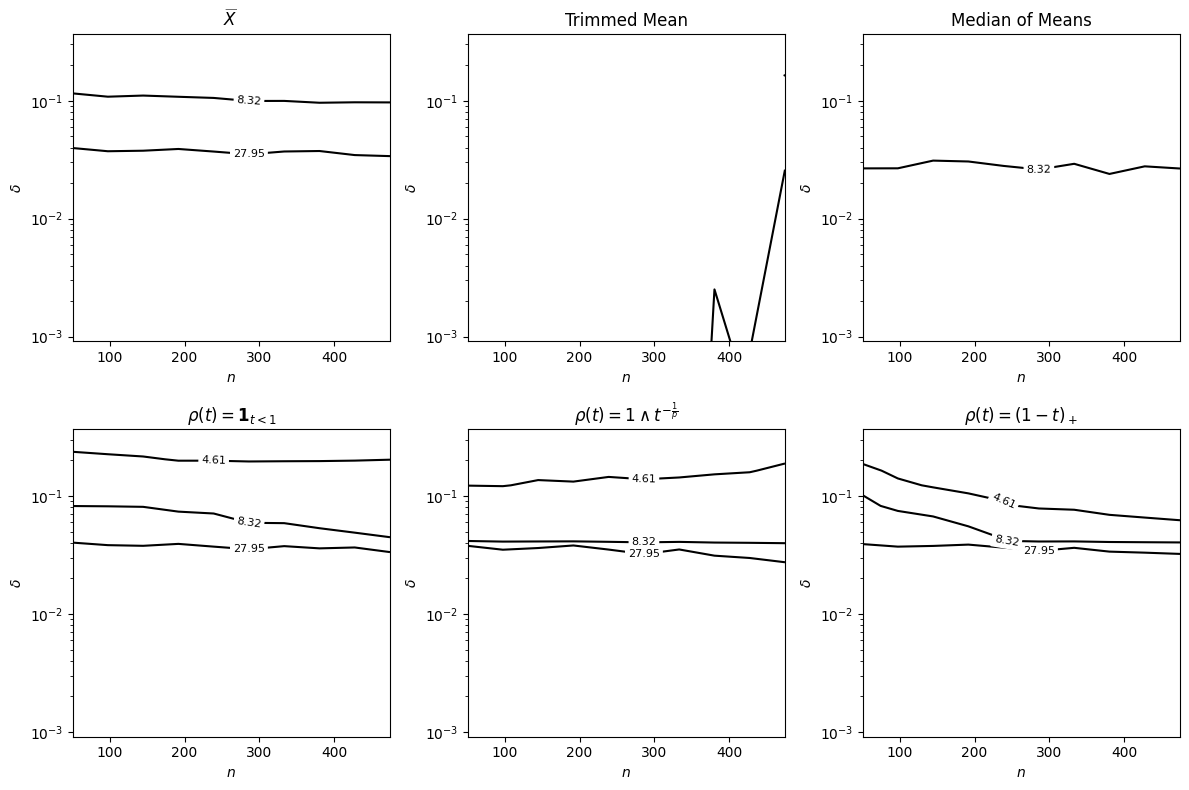

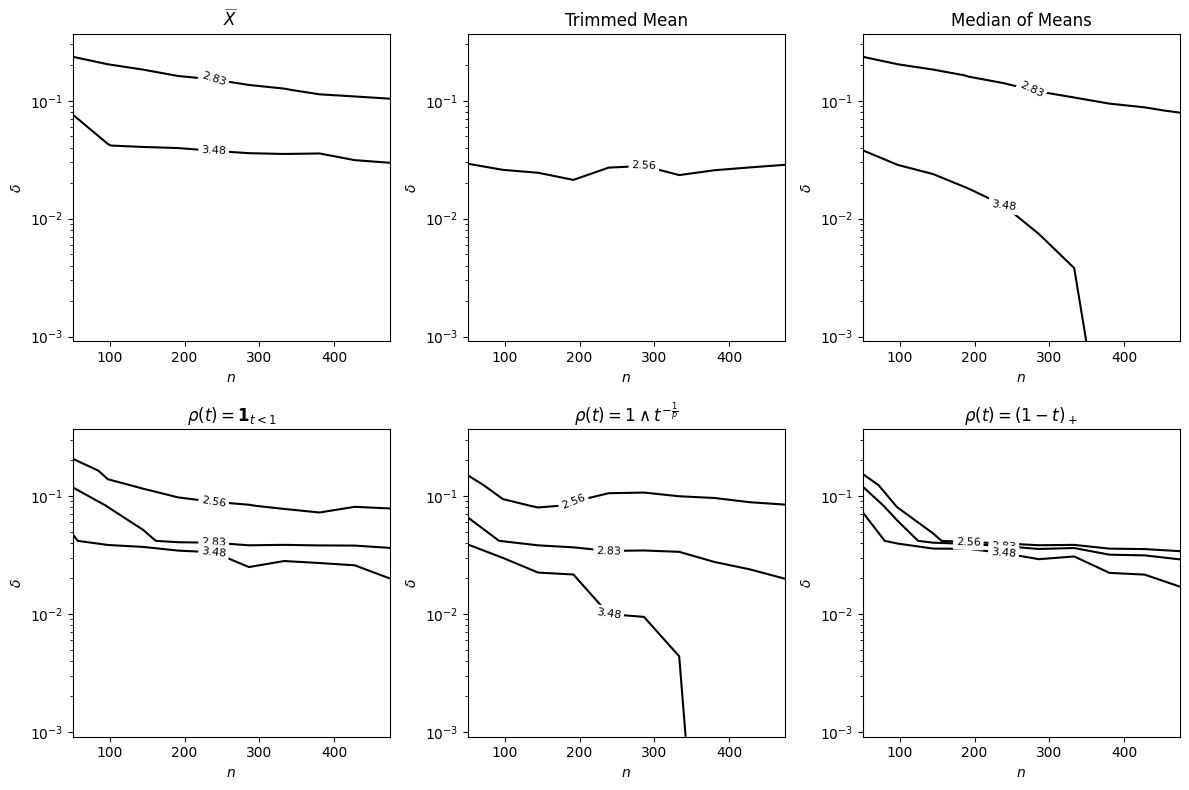

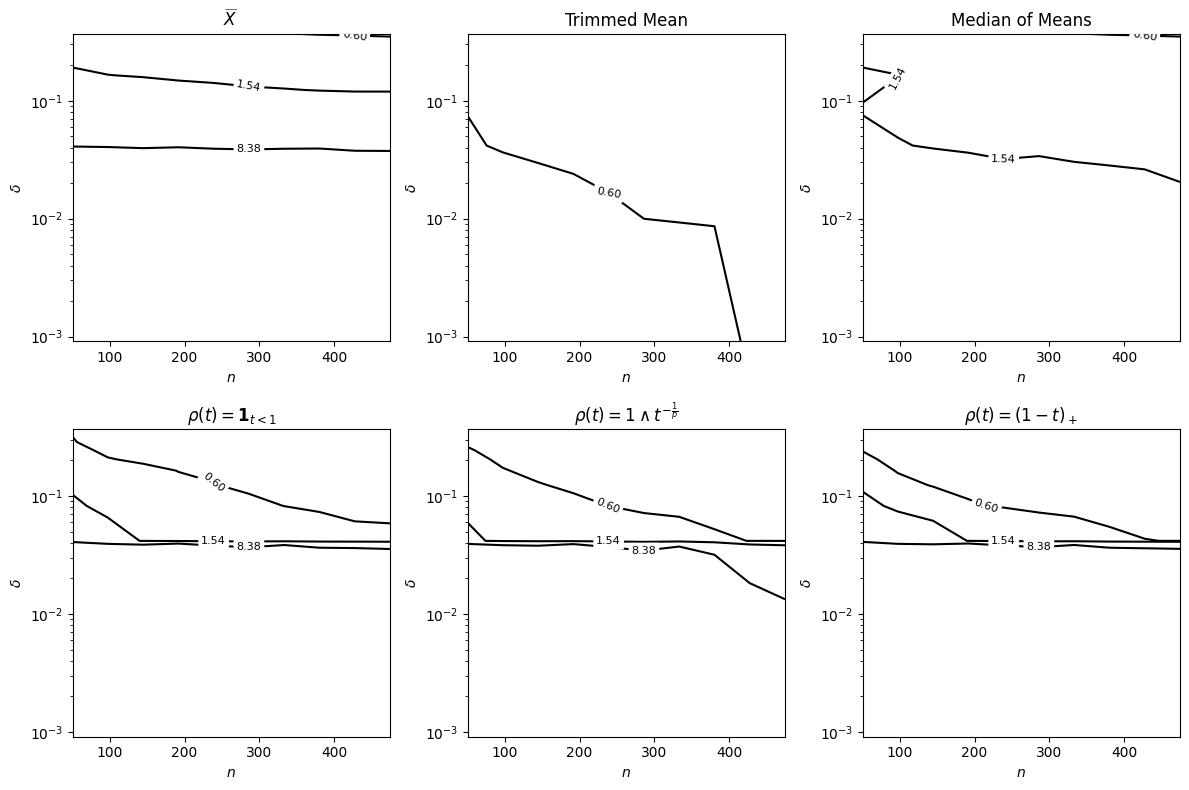

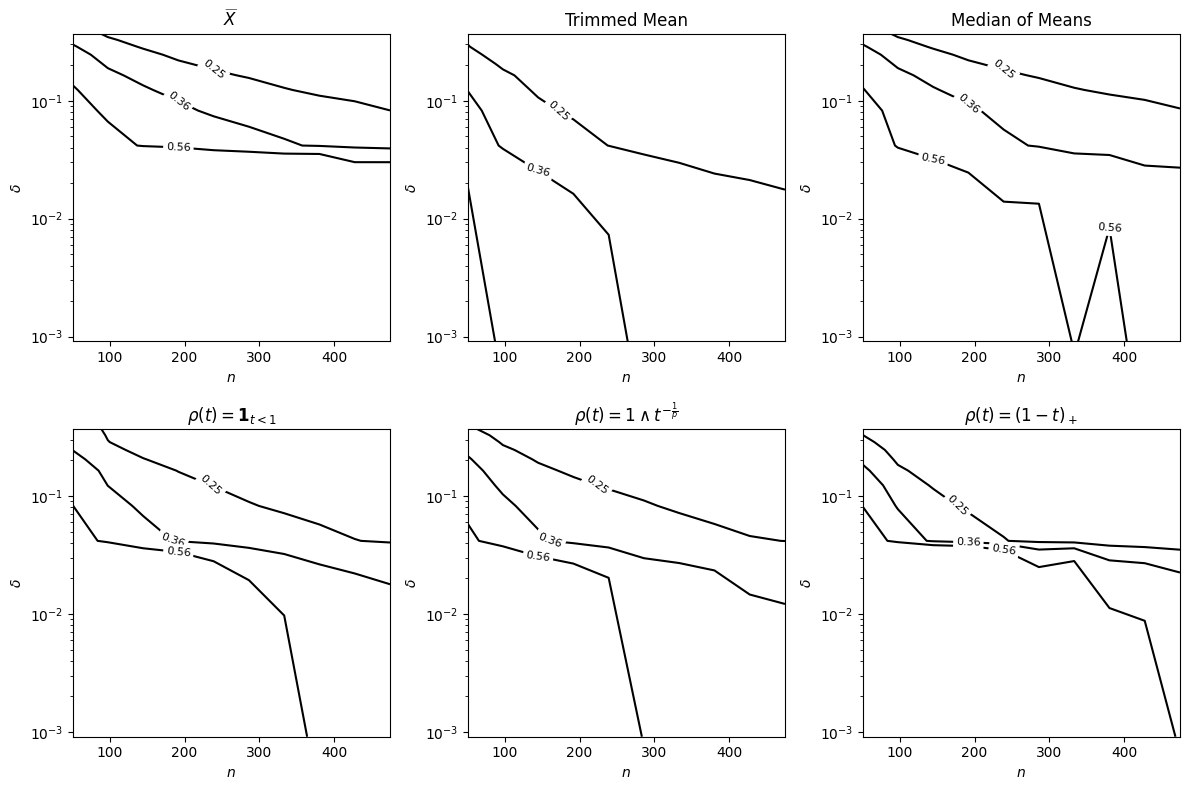

In [17]:
def plot_contour(x,y,z,resolution = 10,contour_method='linear'):
    resolution = str(resolution)+'j'
    X,Y = np.mgrid[min(x):max(x):complex(resolution), min(y):max(y):complex(resolution)]
    points = [[a,b] for a,b in zip(x,y)]
    Z = griddata(points, z, (X, Y), method=contour_method)
    return X,Y,Z

def get_levels(v):
    return np.quantile(v, np.linspace(0,1,5))

for distribution in range_distributions:
    df = experiments[ experiments["distribution"] == distribution ]
    fig, (axs) = plt.subplots(nrows=2, ncols=3, figsize=(12,8))

    # df_grouped = [ df[ df["delta"] == delta ].groupby(["n", "delta", "method"])["error_squared"].mean().reset_index() for delta in range_deltas ]
    df_grouped = [ df[ df["delta"] == delta ].groupby(["n", "delta", "method"])["error"].quantile(1-delta).reset_index() for delta in range_deltas ]
    df_grouped = pd.concat(df_grouped)
    
    levels = get_levels(df_grouped["error"].values)
    labels = [r"$\widebar{X}$", "Trimmed Mean", "Median of Means", r"$\rho(t) = \mathbf{1}_{t < 1}$", r"$\rho(t) = 1 \wedge t^{-\frac{1}{p}}$", r"$\rho(t) = (1-t)_+$"]

    for ax, method, label in zip(axs.flatten(), ["mean", "tm", "mom", "atm", "win", "lv"], labels):
        x = df_grouped[df_grouped["method"] == method]["n"].values
        y = df_grouped[df_grouped["method"] == method]["delta"].values
        z = df_grouped[df_grouped["method"] == method]["error"].values
        w = 1*(z < df_grouped[df_grouped["method"] == "mean"]["error"].values)

        X,Y,Z = plot_contour(x,y,z,resolution = 10,contour_method='linear')
        CS4 = ax.contour(X,Y,Z, levels, colors="black" ) 
        CB = ax.clabel(CS4, fmt='%2.2f', colors='black', fontsize=8, inline=False)
        [txt.set_bbox(dict(boxstyle='square,pad=.2',fc='white', ec='white')) for txt in CB]

        # X,Y,W = plot_contour(x,y,w,resolution = 10, contour_method='linear')
        # ax.contourf(X,Y,W, [.99,1.1], alpha=.2, antialiased=False) 

        ax.set_yscale('log')
        ax.set_xlabel(r"$n$")
        ax.set_ylabel(r"$\delta$")
        ax.set_title(label)
    fig.tight_layout()
    fig.savefig(distribution + "_mse.png")